In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import das bibliotecas
import numpy    as np
import pandas   as pd
import seaborn  as sns
import lightgbm as lgb
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Import do dataset publico pra tabela pandas
dadosPublicos = pd.read_csv('Dataset_publico.csv',sep = ';', encoding = 'latin-1')

dadosPublicos

,ID,ID_UOR,TS_INC_EPR,TS_INC_CHMD
0,0,0,2020-09-01 10:01:24,2020-09-01 10:02:13
1,1,0,2020-09-01 10:04:21,2020-09-01 10:22:01
2,2,0,2020-09-01 10:16:14,2020-09-01 10:25:06
3,3,0,2020-09-01 10:28:38,2020-09-01 10:28:40
4,4,0,2020-09-01 10:37:38,2020-09-01 10:37:41
...,...,...,...,...
335607,376677,24,2021-07-30 13:05:56,2021-07-30 13:06:35
335608,376678,24,2021-07-30 13:12:09,2021-07-30 13:15:53
335609,376679,24,2021-07-30 13:17:08,2021-07-30 13:17:31
335610,376680,24,2021-07-30 13:27:15,2021-07-30 13:27:29


In [4]:
# Importando dados de teste
dadosTeste = pd.read_csv('X.csv',sep = ';', encoding = 'latin-1')

# Transforma a coluna DT para Datetime
dadosTeste['DT'] = pd.to_datetime(dadosTeste['DT'], infer_datetime_format=True)

# Cria a coluna PC_ACI_PZ que será predita. float64 - NaN
dadosTeste['PC_ACI_PZ'] = 0.00
dadosTeste['PC_ACI_PZ'] = np.NaN

# Incrementa o ID em 100000 para não duplicar registros na junção treino / teste
dadosTeste['ID'] = dadosTeste['ID']+100000

dadosTeste

,ID,ID_UOR,DT,HH_INC,HH_FIM,PC_ACI_PZ
0,100000,0,2021-08-02,10:00:00,10:59:59,NaN
1,100001,0,2021-08-02,11:00:00,11:59:59,NaN
2,100002,0,2021-08-02,12:00:00,12:59:59,NaN
3,100003,0,2021-08-02,13:00:00,13:59:59,NaN
4,100004,0,2021-08-02,14:00:00,14:59:59,NaN
...,...,...,...,...,...,...
2635,102635,24,2021-08-31,10:00:00,10:59:59,NaN
2636,102636,24,2021-08-31,11:00:00,11:59:59,NaN
2637,102637,24,2021-08-31,12:00:00,12:59:59,NaN
2638,102638,24,2021-08-31,13:00:00,13:59:59,NaN


In [5]:
# Confere o período dos dados disponíveis
print('Menor data dados publicos: ', dadosPublicos['TS_INC_EPR'].min())
print('Maior data dados publicos: ', dadosPublicos['TS_INC_EPR'].max())
print('Menor data dados teste: ',    dadosTeste['DT'].min())
print('Maior data dados teste: ',    dadosTeste['DT'].max())

Menor data dados publicos:  2020-09-01 09:04:14
Maior data dados publicos:  2021-07-30 15:24:18
Menor data dados teste:  2021-08-02 00:00:00
Maior data dados teste:  2021-08-31 00:00:00


In [6]:
# Verifica presença de 184 registros com valor null em TS_INC_CHMD (FIM_ESPERA).
# O tempo de espera será preenchido com a média.
dadosPublicos.count()

ID             335612
ID_UOR         335612
TS_INC_EPR     335612
TS_INC_CHMD    335428
dtype: int64

In [7]:
# Faz cópia da tabela dadosPublicos
dadosTratados = dadosPublicos.copy()

# Converte as colunas de TS_INC_EPR e TS_INC_CHMD para o formato DateTime
dadosTratados['INICIO_ESPERA'] = pd.to_datetime(dadosTratados['TS_INC_EPR'], infer_datetime_format=True)
dadosTratados['FIM_ESPERA'] = pd.to_datetime(dadosTratados['TS_INC_CHMD'], infer_datetime_format=True)

# Dropa as colunas originais
dadosTratados = dadosTratados.drop(columns=['TS_INC_EPR', 'TS_INC_CHMD'])

# Cria a coluna TEMPO_ESPERA_MINUTOS
dadosTratados['TEMPO_ESPERA_MINUTOS'] = (dadosTratados['FIM_ESPERA'] - 
                                         dadosTratados['INICIO_ESPERA']) / np.timedelta64(1,'m')

dadosTratados = dadosTratados.round({'TEMPO_ESPERA_MINUTOS': 2})

# Preenche o tempo de espera dos registros com a média de espera.
dadosTratados['TEMPO_ESPERA_MINUTOS'] = dadosTratados['TEMPO_ESPERA_MINUTOS'].fillna(dadosTratados['TEMPO_ESPERA_MINUTOS'].mean())

# Dropa a coluna FIM_ESPERA que não será mais utilizada
dadosTratados = dadosTratados.drop(columns=['FIM_ESPERA'])

# Cria a coluna DT - Extraindo a data da coluna INICIO_ESPERA
dadosTratados['DT'] = pd.to_datetime(dadosTratados['INICIO_ESPERA'].dt.date, infer_datetime_format=True)

# Cria a coluna HORA - Extraindo a hora da coluna INICIO_ESPERA
dadosTratados['HORA'] = dadosTratados['INICIO_ESPERA'].dt.time

# Cria a coluna HH
dadosTratados['HH'] = pd.to_numeric(dadosTratados['HORA'].astype(str).str[:2])
dadosTratados['HH'] = np.select(
   [
      dadosTratados['HH'] < 10, 
      dadosTratados['HH'] > 14
    ], 
    [
        10,
        14
    ], 
    default=dadosTratados['HH']
)

# Cria a coluna HH_INC
dadosTratados['HH_INC'] = dadosTratados['HH'].astype(str) + ':00:00'

# Cria a coluna HH_FIM
dadosTratados['HH_FIM'] = dadosTratados['HH'].astype(str) + ':59:59'

# Dropa a coluna INICIO_ESPERA e HORA que não serão mais utilizadas
dadosTratados = dadosTratados.drop(columns=['INICIO_ESPERA','HORA'])

# Reordena as colunas
dadosTratados = dadosTratados[['ID',
                               'ID_UOR',
                               'DT', 
                               'HH',
                               'HH_INC',
                               'HH_FIM',
                               'TEMPO_ESPERA_MINUTOS']]

dadosTratados

,ID,ID_UOR,DT,HH,HH_INC,HH_FIM,TEMPO_ESPERA_MINUTOS
0,0,0,2020-09-01,10,10:00:00,10:59:59,0.82
1,1,0,2020-09-01,10,10:00:00,10:59:59,17.67
2,2,0,2020-09-01,10,10:00:00,10:59:59,8.87
3,3,0,2020-09-01,10,10:00:00,10:59:59,0.03
4,4,0,2020-09-01,10,10:00:00,10:59:59,0.05
...,...,...,...,...,...,...,...
335607,376677,24,2021-07-30,13,13:00:00,13:59:59,0.65
335608,376678,24,2021-07-30,13,13:00:00,13:59:59,3.73
335609,376679,24,2021-07-30,13,13:00:00,13:59:59,0.38
335610,376680,24,2021-07-30,13,13:00:00,13:59:59,0.23


Quantidade de registros:  335612
Maior valor de espera:  269.33


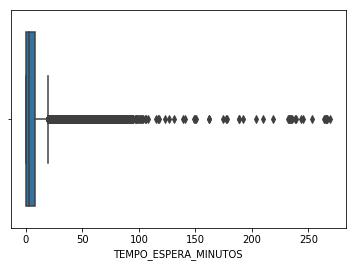

In [8]:
# Verifica presença de outliers ao analisar o tempo de espera
print('Quantidade de registros: ', dadosTratados['TEMPO_ESPERA_MINUTOS'].count())
print('Maior valor de espera: ', dadosTratados['TEMPO_ESPERA_MINUTOS'].max())
sns.boxplot(x=dadosTratados['TEMPO_ESPERA_MINUTOS'])

Quantidade de registros:  335105
Maior valor de espera:  59.15


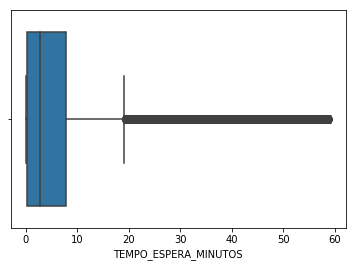

In [9]:
# Remove outliers com ZScore
z = np.abs(stats.zscore(dadosTratados[['TEMPO_ESPERA_MINUTOS']]))
dadosTratados = dadosTratados[(z < 7).all(axis=1)]

# Plota novamente a distribuição
print('Quantidade de registros: ', dadosTratados['TEMPO_ESPERA_MINUTOS'].count())
print('Maior valor de espera: ', dadosTratados['TEMPO_ESPERA_MINUTOS'].max())
sns.boxplot(x=dadosTratados['TEMPO_ESPERA_MINUTOS'])

In [10]:
# Gera a tabela de média de espera em minutos por UOR, DIA e HH
temp1 = dadosTratados.copy()
temp1['DIA'] = temp1['DT'].dt.day
temp1 = temp1.drop(columns=['ID','DT','HH_INC','HH_FIM'])
temp1 = temp1.groupby(['ID_UOR','DIA','HH']).mean().reset_index()
temp1 = temp1.round({'TEMPO_ESPERA_MINUTOS': 2})
resumoMinutos = temp1.rename(columns={ "TEMPO_ESPERA_MINUTOS": "MD_TEMPO_ESPERA_MINUTOS"})
resumoMinutos

,ID_UOR,DIA,HH,MD_TEMPO_ESPERA_MINUTOS
0,0,1,10,5.10
1,0,1,11,6.51
2,0,1,12,5.06
3,0,1,13,5.65
4,0,1,14,6.30
...,...,...,...,...
3493,24,31,10,6.60
3494,24,31,11,5.65
3495,24,31,12,3.76
3496,24,31,13,8.03


In [11]:
# Cria uma tabela de resumo com algumas métricas
t0 = dadosTratados.drop(columns=['ID'])

t1 = t0.groupby(['ID_UOR',
                 'DT',
                 'HH',
                 'HH_INC',
                 'HH_FIM']).size().to_frame('QTD_TOTAL').reset_index()

t2 = t0.loc[t0['TEMPO_ESPERA_MINUTOS'] > 15].groupby(['ID_UOR',
                                                      'DT','HH',
                                                      'HH_INC',
                                                      'HH_FIM']).size().to_frame('QTD_ACIMA').reset_index()

t3 = t0.loc[t0['TEMPO_ESPERA_MINUTOS'] <= 15].groupby(['ID_UOR',
                                                       'DT',
                                                       'HH',
                                                       'HH_INC',
                                                       'HH_FIM']).size().to_frame('QTD_ABAIXO').reset_index()

resumoDadosTratados = t1.merge(t2,on=[
    'ID_UOR',
    'DT',
    'HH',
    'HH_INC',
    'HH_FIM'],how='left').merge(t3,on=[
    'ID_UOR',
    'DT',
    'HH',
    'HH_INC',
    'HH_FIM'],how='left')

resumoDadosTratados['QTD_ACIMA']  = pd.to_numeric(resumoDadosTratados['QTD_ACIMA'].fillna(0), downcast='integer')

resumoDadosTratados['QTD_ABAIXO'] = pd.to_numeric(resumoDadosTratados['QTD_ABAIXO'].fillna(0), downcast='integer')

resumoDadosTratados['PC_ACI_PZ'] = (resumoDadosTratados['QTD_ACIMA'] / resumoDadosTratados['QTD_TOTAL']) * 100

resumoDadosTratados['PC_ABA_PZ'] = (100-resumoDadosTratados['PC_ACI_PZ'])

resumoDadosTratados = resumoDadosTratados.round({'PC_ACI_PZ': 2,
                                                 'PC_ABA_PZ': 2})

resumoDadosTratados['DIA'] = resumoDadosTratados['DT'].dt.day

resumoDadosTratados['ID'] = resumoDadosTratados.index

resumoDadosTratados

,ID_UOR,DT,HH,HH_INC,HH_FIM,QTD_TOTAL,QTD_ACIMA,QTD_ABAIXO,PC_ACI_PZ,PC_ABA_PZ,DIA,ID
0,0,2020-09-01,10,10:00:00,10:59:59,12,1,11,8.33,91.67,1,0
1,0,2020-09-02,10,10:00:00,10:59:59,23,0,23,0.00,100.00,2,1
2,0,2020-09-02,11,11:00:00,11:59:59,10,0,10,0.00,100.00,2,2
3,0,2020-09-02,12,12:00:00,12:59:59,14,0,14,0.00,100.00,2,3
4,0,2020-09-02,13,13:00:00,13:59:59,16,0,16,0.00,100.00,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
20864,24,2021-07-29,13,13:00:00,13:59:59,4,0,4,0.00,100.00,29,20864
20865,24,2021-07-30,10,10:00:00,10:59:59,4,0,4,0.00,100.00,30,20865
20866,24,2021-07-30,11,11:00:00,11:59:59,7,0,7,0.00,100.00,30,20866
20867,24,2021-07-30,12,12:00:00,12:59:59,5,0,5,0.00,100.00,30,20867


In [12]:
# Obtem dados de treino através do resumo
dadosTreino = resumoDadosTratados[['ID',
                                   'ID_UOR',
                                   'DT',
                                   'HH_INC',
                                   'HH_FIM',
                                   'PC_ACI_PZ']]
dadosTreino

,ID,ID_UOR,DT,HH_INC,HH_FIM,PC_ACI_PZ
0,0,0,2020-09-01,10:00:00,10:59:59,8.33
1,1,0,2020-09-02,10:00:00,10:59:59,0.00
2,2,0,2020-09-02,11:00:00,11:59:59,0.00
3,3,0,2020-09-02,12:00:00,12:59:59,0.00
4,4,0,2020-09-02,13:00:00,13:59:59,0.00
...,...,...,...,...,...,...
20864,20864,24,2021-07-29,13:00:00,13:59:59,0.00
20865,20865,24,2021-07-30,10:00:00,10:59:59,0.00
20866,20866,24,2021-07-30,11:00:00,11:59:59,0.00
20867,20867,24,2021-07-30,12:00:00,12:59:59,0.00


In [13]:
# Une dados de treino e teste para facilitar o tratamento
dados = pd.concat([dadosTreino, dadosTeste])
dados

,ID,ID_UOR,DT,HH_INC,HH_FIM,PC_ACI_PZ
0,0,0,2020-09-01,10:00:00,10:59:59,8.33
1,1,0,2020-09-02,10:00:00,10:59:59,0.00
2,2,0,2020-09-02,11:00:00,11:59:59,0.00
3,3,0,2020-09-02,12:00:00,12:59:59,0.00
4,4,0,2020-09-02,13:00:00,13:59:59,0.00
...,...,...,...,...,...,...
2635,102635,24,2021-08-31,10:00:00,10:59:59,NaN
2636,102636,24,2021-08-31,11:00:00,11:59:59,NaN
2637,102637,24,2021-08-31,12:00:00,12:59:59,NaN
2638,102638,24,2021-08-31,13:00:00,13:59:59,NaN


In [14]:
# Obtem a tabela de métricas para cada UOR / DIA / HH
resumoTotal = resumoDadosTratados[['ID_UOR',
                                   'DIA',
                                   'HH',
                                   'QTD_ABAIXO',
                                   'QTD_ACIMA',
                                   'QTD_TOTAL',
                                   'PC_ABA_PZ',
                                   'PC_ACI_PZ']].groupby(['ID_UOR',
                                                          'DIA',
                                                          'HH']).mean().reset_index()

resumoTotal = resumoTotal.round({'QTD_TOTAL' :2,
                                 'QTD_ACIMA' :2,
                                 'QTD_ABAIXO':2,
                                 'PC_ABA_PZ' :2,
                                 'PC_ACI_PZ' :2})

resumoTotal = resumoTotal.rename(columns={ "QTD_TOTAL" : "MD_TOTAL",
                                           "QTD_ACIMA" : "MD_ACIMA",
                                           "QTD_ABAIXO": "MD_ABAIXO",
                                           "PC_ABA_PZ" : "MD_PC_ABA_PZ",
                                           "PC_ACI_PZ" : "MD_PC_ACI_PZ"})

resumoTotal

,ID_UOR,DIA,HH,MD_ABAIXO,MD_ACIMA,MD_TOTAL,MD_PC_ABA_PZ,MD_PC_ACI_PZ
0,0,1,10,20.25,0.75,21.00,96.08,3.92
1,0,1,11,17.86,1.14,19.00,94.69,5.31
2,0,1,12,17.14,0.29,17.43,98.41,1.59
3,0,1,13,16.43,2.00,18.43,89.39,10.61
4,0,1,14,9.86,0.71,10.57,96.24,3.76
...,...,...,...,...,...,...,...,...
3493,24,31,10,6.00,1.00,7.00,88.89,11.11
3494,24,31,11,6.00,0.50,6.50,93.75,6.25
3495,24,31,12,3.00,0.00,3.00,100.00,0.00
3496,24,31,13,5.50,0.50,6.00,94.44,5.56


In [15]:
# Transformações nas tabelas de treino e teste
final = dados

# - Cria a coluna hora
final['HH'] = pd.to_numeric(final['HH_INC'].astype(str).str[:2])

# - Cria a coluna dia
final['DIA'] = final['DT'].dt.day

# - Cria a coluna mes
final['MES'] = final['DT'].dt.month

# - Cria a coluna ano
final['ANO'] = final['DT'].dt.year

# - Cria a coluna dia da semana
final['DIA_DA_SEMANA'] = final['DT'].dt.dayofweek

# - Cria a coluna periodo do dia
final['PERIODO_DO_DIA'] = np.select(
    [
        final['HH_INC'] == '10:00:00', 
        final['HH_INC'] == '11:00:00',
        final['HH_INC'] == '12:00:00',
        final['HH_INC'] == '13:00:00',
        final['HH_INC'] == '14:00:00'
    ], 
    [
        1, # Manhã
        1, # Manhã
        2, # Almoço
        3, # Tarde
        3  # Tarde
    ], 
    default=0
)

# - Cria a coluna periodo do dia
final['VESPERA_FERIADO'] = np.select(
    [
        final['DT'] == '2020-02-21', # Véspera Carnaval
        final['DT'] == '2020-04-09', # Véspera Sexta Feira Santa
        final['DT'] == '2020-04-20', # Véspera Tiradentes
        final['DT'] == '2020-04-30', # Véspera Dia do Trabalho
        final['DT'] == '2020-06-10', # Véspera Corpus Christi
        final['DT'] == '2020-09-04', # Véspera Independência
        final['DT'] == '2020-10-09', # Véspera Nossa Senhora Aparecida
        final['DT'] == '2020-10-30', # Véspera Finados
        final['DT'] == '2020-12-30', # Véspera Dia 1
        final['DT'] == '2021-02-12', # Véspera Carnaval
        final['DT'] == '2021-04-01', # Véspera Páscoa
        final['DT'] == '2021-04-20', # Véspera Tiradentes
        final['DT'] == '2021-04-30', # Véspera Dia do Trabalho
        final['DT'] == '2021-06-02', # Véspera Corpus Christi
        final['DT'] == '2021-09-06', # Véspera Independência
        final['DT'] == '2021-10-11', # Véspera Nossa Senhora Aparecida
        final['DT'] == '2021-11-01', # Véspera Finados
        final['DT'] == '2021-11-12', # Véspera República
        final['DT'] == '2021-12-30'  # Véspera Dia 1        
    ], 
    [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1
    ], 
    default=0
)

# - Cria a coluna periodo da semana
final['PERIODO_DA_SEMANA'] = np.select(
    [
        final['DT'].dt.dayofweek.between( 0, 1, inclusive='both'),
        final['DT'].dt.dayofweek.between( 2, 2, inclusive='both'),
        final['DT'].dt.dayofweek.between( 3, 4, inclusive='both')
    ], 
    [
        1, # Início
        2, # Meio
        3  # Fim
    ], 
    default=0
)

# - Cria a coluna período do mês
final['PERIODO_DO_MES'] = np.select(
    [
        final['DT'].dt.day.between(  1, 10, inclusive='both'),
        final['DT'].dt.day.between( 11, 20, inclusive='both'),
        final['DT'].dt.day.between( 21, 31, inclusive='both')
    ], 
    [
        1, # Início do Mês
        2, # Meio do Mês
        3  # Final do Mês
    ], 
    default=0
)

# - Cria a coluna trimestre
final['TRIMESTRE'] = np.select(
    [
        final['DT'].dt.month.between( 1, 3, inclusive='both'),
        final['DT'].dt.month.between( 4, 6, inclusive='both'),
        final['DT'].dt.month.between( 6, 9, inclusive='both'),
        final['DT'].dt.month.between( 10, 12, inclusive='both')
    ], 
    [
        1, # 1 Trimestre
        2, # 2 Trimestre
        3, # 3 Trimestre
        4  # 4 Trimestre
    ], 
    default=0
)

# - Cria a coluna booleana DIA_5 (quinto dia últil, muito movimento nos caixas)
final['DIA_5'] = np.select(
    [
        final['DT'] == '2020-01-08',
        final['DT'] == '2020-02-07',
        final['DT'] == '2020-03-06',
        final['DT'] == '2020-04-07',
        final['DT'] == '2020-05-08',
        final['DT'] == '2020-06-05',
        final['DT'] == '2020-07-07',
        final['DT'] == '2020-08-07',
        final['DT'] == '2020-09-08',
        final['DT'] == '2020-10-07',
        final['DT'] == '2020-11-09',
        final['DT'] == '2020-12-07',
        final['DT'] == '2021-01-07',
        final['DT'] == '2021-02-07',
        final['DT'] == '2021-03-08',
        final['DT'] == '2021-04-07',
        final['DT'] == '2021-05-06',
        final['DT'] == '2021-06-07',
        final['DT'] == '2021-07-07',
        final['DT'] == '2021-08-06',
        final['DT'] == '2021-09-08',
        final['DT'] == '2021-10-07',
        final['DT'] == '2021-11-08',
        final['DT'] == '2021-12-07'
    ], 
    [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1
    ], 
    default=0
)

# - Cria a coluna booleana DIA_10 (dia ou sua véspera - dia de vencimento de muitas contas)
final['DIA_10'] = np.select(
    [
        final['DT'] == '2020-01-10',
        final['DT'] == '2020-02-10',
        final['DT'] == '2020-03-10',
        final['DT'] == '2020-04-09',
        final['DT'] == '2020-05-08',
        final['DT'] == '2020-06-10',
        final['DT'] == '2020-07-10',
        final['DT'] == '2020-08-10',
        final['DT'] == '2020-09-10',
        final['DT'] == '2020-10-09',
        final['DT'] == '2020-11-10',
        final['DT'] == '2020-12-10',
        final['DT'] == '2021-01-10',
        final['DT'] == '2021-02-10',
        final['DT'] == '2021-03-10',
        final['DT'] == '2021-04-08',
        final['DT'] == '2021-05-10',
        final['DT'] == '2021-06-10',
        final['DT'] == '2021-07-08',
        final['DT'] == '2021-08-10',
        final['DT'] == '2021-09-10',
        final['DT'] == '2021-10-08',
        final['DT'] == '2021-11-10',
        final['DT'] == '2021-12-10'
    ], 
    [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1
    ], 
    default=0
)

# - Cria a coluna ESPECIAL - Natal/2020 e Cinzas/2021 (dados vão de 09/2020 a 07/2021) - Verificar a base de teste
final['ESPECIAL'] = np.select(
    [
        final['DT'].between('2020-12-24','2020-12-24'),
        final['DT'].between('2021-02-17','2021-02-17')
    ], 
    [
        1,
        1
    ], 
    default=0
)

temp1 = final.merge(resumoTotal,on=['ID_UOR',
                                    'DIA',
                                    'HH'],how='left').merge(resumoMinutos,on=['ID_UOR',
                                                                              'DIA',
                                                                              'HH'],how='left')

# - Para os casos em que o merge não obteve dados (aprox 180 registros), preencher com média
temp1['MD_ABAIXO'] = temp1['MD_ABAIXO'].fillna(temp1['MD_ABAIXO'].mean())
temp1['MD_ACIMA'] = temp1['MD_ACIMA'].fillna(temp1['MD_ACIMA'].mean())
temp1['MD_TOTAL'] = temp1['MD_TOTAL'].fillna(temp1['MD_TOTAL'].mean())
temp1['MD_PC_ABA_PZ'] = temp1['MD_PC_ABA_PZ'].fillna(temp1['MD_PC_ABA_PZ'].mean())
temp1['MD_PC_ACI_PZ'] = temp1['MD_PC_ACI_PZ'].fillna(temp1['MD_PC_ACI_PZ'].mean())
temp1['MD_TEMPO_ESPERA_MINUTOS'] = temp1['MD_TEMPO_ESPERA_MINUTOS'].fillna(temp1['MD_TEMPO_ESPERA_MINUTOS'].mean())

# - Ordena a tabela final
tabelaFinal = temp1[['ID_UOR',                  # 0
                     'DIA',                     # 1
                     'MES',                     # 2
                     'ANO',                     # 3
                     'HH',                      # 4
                     'DIA_DA_SEMANA',           # 5
                     'PERIODO_DO_DIA',          # 6
                     'PERIODO_DA_SEMANA',       # 7
                     'PERIODO_DO_MES',          # 8
                     'TRIMESTRE',               # 9
                     'DIA_5',                   # 10
                     'DIA_10',                  # 11
                     'ESPECIAL',                # 12
                     'VESPERA_FERIADO',         # 13
                     'MD_ABAIXO',               # 14
                     'MD_ACIMA',                # 15
                     'MD_TOTAL',                # 16
                     'MD_PC_ABA_PZ',            # 17
                     'MD_PC_ACI_PZ',            # 18
                     'MD_TEMPO_ESPERA_MINUTOS', # 19
                     'PC_ACI_PZ']]              # 20

tabelaFinal

,ID_UOR,DIA,MES,ANO,HH,DIA_DA_SEMANA,PERIODO_DO_DIA,PERIODO_DA_SEMANA,PERIODO_DO_MES,TRIMESTRE,...,DIA_10,ESPECIAL,VESPERA_FERIADO,MD_ABAIXO,MD_ACIMA,MD_TOTAL,MD_PC_ABA_PZ,MD_PC_ACI_PZ,MD_TEMPO_ESPERA_MINUTOS,PC_ACI_PZ
0,0,1,9,2020,10,1,1,1,1,3,...,0,0,0,20.25,0.75,21.00,96.08,3.92,5.10,8.33
1,0,2,9,2020,10,2,1,2,1,3,...,0,0,0,21.57,1.43,23.00,93.20,6.80,6.17,0.00
2,0,2,9,2020,11,2,1,2,1,3,...,0,0,0,16.86,1.71,18.57,91.42,8.58,6.22,0.00
3,0,2,9,2020,12,2,2,2,1,3,...,0,0,0,12.43,2.57,15.00,79.71,20.29,6.60,0.00
4,0,2,9,2020,13,2,3,2,1,3,...,0,0,0,18.00,1.14,19.14,93.10,6.90,4.64,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23504,24,31,8,2021,10,1,1,1,3,3,...,0,0,0,6.00,1.00,7.00,88.89,11.11,6.60,NaN
23505,24,31,8,2021,11,1,1,1,3,3,...,0,0,0,6.00,0.50,6.50,93.75,6.25,5.65,NaN
23506,24,31,8,2021,12,1,2,1,3,3,...,0,0,0,3.00,0.00,3.00,100.00,0.00,3.76,NaN
23507,24,31,8,2021,13,1,3,1,3,3,...,0,0,0,5.50,0.50,6.00,94.44,5.56,8.03,NaN


In [16]:
# Normaliza e Padroniza as variáveis quantitativas
array = tabelaFinal.values

# Normaliza - valores de 0 a 1
naoNormalizar0 = array[:,0:14]
paraNormalizar = array[:,14:20]
naoNormalizar = array[:,20]

scaler = MinMaxScaler(feature_range=(0,1))
normalizadas = scaler.fit_transform(paraNormalizar)

# Padroniza - Média 0, Desvio Padrão 1
scaler = StandardScaler().fit(normalizadas)
padronizadas = scaler.transform(normalizadas)

npadro0 = pd.DataFrame(naoNormalizar0, columns = ['ID_UOR',
                                                  'DIA',
                                                  'MES',
                                                  'ANO',
                                                  'HH',
                                                  'DIA_DA_SEMANA',
                                                  'PERIODO_DO_DIA',
                                                  'PERIODO_DA_SEMANA',
                                                  'PERIODO_DO_MES',
                                                  'TRIMESTRE',
                                                  'DIA_5',
                                                  'DIA_10',
                                                  'ESPECIAL',
                                                  'VESPERA_FERIADO'])

padron = pd.DataFrame(padronizadas, columns = ['MD_ABAIXO',
                                               'MD_ACIMA',
                                               'MD_TOTAL',
                                               'MD_PC_ABA_PZ',
                                               'MD_PC_ACI_PZ',
                                               'MD_TEMPO_ESPERA_MINUTOS'])

npadro  = pd.DataFrame(naoNormalizar, columns = ['PC_ACI_PZ'])

tbFinal = pd.concat([npadro0,padron, npadro], axis=1)

tbFinal

,ID_UOR,DIA,MES,ANO,HH,DIA_DA_SEMANA,PERIODO_DO_DIA,PERIODO_DA_SEMANA,PERIODO_DO_MES,TRIMESTRE,...,DIA_10,ESPECIAL,VESPERA_FERIADO,MD_ABAIXO,MD_ACIMA,MD_TOTAL,MD_PC_ABA_PZ,MD_PC_ACI_PZ,MD_TEMPO_ESPERA_MINUTOS,PC_ACI_PZ
0,0.0,1.0,9.0,2020.0,10.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.645086,-0.245866,0.471621,0.290504,-0.290505,0.284385,8.33
1,0.0,2.0,9.0,2020.0,10.0,2.0,1.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.793853,0.003454,0.658293,-0.051376,0.051376,0.602542,0.00
2,0.0,2.0,9.0,2020.0,11.0,2.0,1.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.263023,0.106115,0.244815,-0.262676,0.262677,0.617409,0.00
3,0.0,2.0,9.0,2020.0,12.0,2.0,2.0,2.0,1.0,3.0,...,0.0,0.0,0.0,-0.236250,0.421431,-0.088394,-1.652748,1.652753,0.730399,0.00
4,0.0,2.0,9.0,2020.0,13.0,2.0,3.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.391504,-0.102874,0.298016,-0.063247,0.063246,0.147607,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23504,24.0,31.0,8.0,2021.0,10.0,1.0,1.0,1.0,3.0,3.0,...,0.0,0.0,0.0,-0.960929,-0.154205,-0.835080,-0.563008,0.563009,0.730399,NaN
23505,24.0,31.0,8.0,2021.0,11.0,1.0,1.0,1.0,3.0,3.0,...,0.0,0.0,0.0,-0.960929,-0.337528,-0.881748,0.013914,-0.013914,0.447923,NaN
23506,24.0,31.0,8.0,2021.0,12.0,1.0,2.0,1.0,3.0,3.0,...,0.0,0.0,0.0,-1.299037,-0.520852,-1.208424,0.755839,-0.755842,-0.114055,NaN
23507,24.0,31.0,8.0,2021.0,13.0,1.0,3.0,1.0,3.0,3.0,...,0.0,0.0,0.0,-1.017280,-0.337528,-0.928416,0.095822,-0.095823,1.155599,NaN


In [17]:
# Tabela de Treino
treino = tbFinal.loc[tbFinal['PC_ACI_PZ'].notnull()]
# Tabela de Teste
teste = tbFinal.loc[tbFinal['PC_ACI_PZ'].isnull()]

In [18]:
# Faz o feature selection

# Array recebendo os valores da tabela final
array  = treino.values # Tabela de Treino
array2 = teste.values # Tabela de Teste

# Variáveis preditoras disponíveis
preditorasDisponiveis = array[:,0:20]

# Variável predita
predita = array[:,20]

# Escolhe as melhores variáveis com SelectKBest / f_classif
melhores_variaveis = SelectKBest(score_func = f_classif, k=18)
fit = melhores_variaveis.fit(preditorasDisponiveis,predita)
features = fit.transform(preditorasDisponiveis)

# Mostra o índice ddas variáveis escolhidas
frame = pd.DataFrame(preditorasDisponiveis)
mascara = melhores_variaveis.get_support()
colunas = frame.columns[mascara]
colunas

Int64Index([0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

In [19]:
# Variáveis preditoras
melhoresPreditoras =   array[:,[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]] # Base de Treino
melhoresPreditoras2 = array2[:,[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]] # Base de Teste

# Divide tabela entre treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(melhoresPreditoras,
                                                    predita,
                                                    test_size = 0.15, # Mesmo percentual do teste
                                                    random_state = 42)

In [19]:
%%time
# Faz o Hyperparameter Tuning do Random Forest Regressor
# Fonte:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#################################################################################################
######                                                                                     ######
######  Na Plataforma Analítica, levou 1 hora para rodar 300 fits  (n_iter = 100 e cv = 3) ######
######                                                                                     ######
#################################################################################################

rf = RandomForestRegressor(random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Random search of parameters, using 2 fold cross validation, search across 50 different
# combinations, and use 2 cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose = 2,
                               n_jobs = 3,
                               random_state=42)

# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: user 7.31 s, sys: 303 ms, total: 7.61 s
Wall time: 56min 39s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=3,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [20]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [20]:
# Cria modelo Random Forest Regressor com os parâmetros indicados pelo tuning
modeloRFR = RandomForestRegressor(n_estimators = 400,
                                  min_samples_split = 2,
                                  min_samples_leaf = 4,
                                  max_features = 'sqrt',
                                  max_depth = 10,
                                  bootstrap = True)
# Treina
modeloRFR.fit(X_train, Y_train)

# Testa
RFR_pred = modeloRFR.predict(X_test)

# Avalia MSE
mse =  metrics.mean_squared_error(Y_test, RFR_pred)

# Quanto mais baixo, melhor
print("O MSE do modelo RFR é:", mse)

O MSE do modelo RFR é: 163.37830896703082


In [21]:
# Cria modelo LightGBM com parâmetros avaliados pelo próprio cientista.
# Futuramente, fazer Hyperparameter Tuning também do LGBM
modeloLGBMR = lgb.LGBMRegressor(objective = 'tweedie',
                                boosting_type = 'dart',
                                num_leaves = 22)

# Treina
modeloLGBMR.fit(X_train, Y_train)

# Testa
LGBMR_pred = modeloLGBMR.predict(X_test)

# Avalia MSE
mse =  metrics.mean_squared_error(Y_test, LGBMR_pred)

# Quanto mais baixo, melhor
print("O MSE do modelo LGBMR é:", mse)

O MSE do modelo LGBMR é: 164.06498504447626


In [22]:
# Verifica os valores preditos em cada um dos algoritmos
p0 = pd.DataFrame(RFR_pred, columns = ['PC_ACI_PZ'])
p0['PC_ACI_PZ'] = pd.to_numeric(p0['PC_ACI_PZ'])

p1 = pd.DataFrame(LGBMR_pred, columns = ['PC_ACI_PZ'])
p1['PC_ACI_PZ'] = pd.to_numeric(p1['PC_ACI_PZ'])

print('Menor valor predito RFR  : ', p0['PC_ACI_PZ'].min())
print('Maior valor predito RFR  : ', p0['PC_ACI_PZ'].max())
print('Menor valor predito LGBMR: ', p1['PC_ACI_PZ'].min())
print('Maior valor predito LGBMR: ', p1['PC_ACI_PZ'].max())

Menor valor predito RFR  :  0.00036388174634276405
Maior valor predito RFR  :  57.602560339905274
Menor valor predito LGBMR:  0.00041520230526014625
Maior valor predito LGBMR:  31.64542898631405


In [23]:
# Depois de avaliar os modelos, parte para a predição na base de teste
XX_train = melhoresPreditoras  # Base de Treino
XX_test  = melhoresPreditoras2 # Base de Teste
YY_train = predita             # Valor alvo de Treino

# Treina com modelo RFR
modeloRFR.fit(XX_train, YY_train)
# Faz as predições com modelo RFR
YY_test_RFR = modeloRFR.predict(XX_test)

# Treina com modelo LGBMR
modeloLGBMR.fit(XX_train, YY_train)
# Faz as predições com modelo LGBMR
YY_test_LGBMR = modeloLGBMR.predict(XX_test)

# Gera a tabela com os valores das previsões.
predicoesRFR = pd.DataFrame(YY_test_RFR, columns = ['PC_ACI_PZ_RFR'])
predicoesRFR['PC_ACI_PZ_RFR'] = pd.to_numeric(predicoesRFR['PC_ACI_PZ_RFR'])
predicoesRFR = predicoesRFR.rename_axis('ID').reset_index()

# Gera a tabela com os valores das previsões.
predicoesLGBMR = pd.DataFrame(YY_test_LGBMR, columns = ['PC_ACI_PZ_LGBMR'])
predicoesLGBMR['PC_ACI_PZ_LGBMR'] = pd.to_numeric(predicoesLGBMR['PC_ACI_PZ_LGBMR'])
predicoesLGBMR = predicoesLGBMR.rename_axis('ID').reset_index()

# Junta as previsões dos dois modelos
predicoes = predicoesRFR.merge(predicoesLGBMR,on=['ID'],how='left')
predicoes

,ID,PC_ACI_PZ_RFR,PC_ACI_PZ_LGBMR
0,0,8.152887,6.482435
1,1,12.208554,9.444015
2,2,30.010630,21.081828
3,3,10.920925,7.345929
4,4,13.065200,8.358661
...,...,...,...
2635,2635,12.487271,9.492485
2636,2636,6.482077,4.339673
2637,2637,0.023639,0.000414
2638,2638,5.797876,3.732278


In [24]:
# Predição final é a média das predições RFR e LGBMR
predicoes['PC_ACI_PZ'] = (0+predicoes['PC_ACI_PZ_RFR']+predicoes['PC_ACI_PZ_LGBMR'])/2
predicoes = predicoes.round({'PC_ACI_PZ': 2})
predicoes = predicoes.drop(columns=['PC_ACI_PZ_RFR', 'PC_ACI_PZ_LGBMR'])
predicoes

,ID,PC_ACI_PZ
0,0,7.32
1,1,10.83
2,2,25.55
3,3,9.13
4,4,10.71
...,...,...
2635,2635,10.99
2636,2636,5.41
2637,2637,0.01
2638,2638,4.77


In [25]:
# Resolvi usar só LGBMR - Remove a média dos dois modelos
#predicoes = predicoesLGBMR
#predicoes = predicoes.rename(columns={ "PC_ACI_PZ_LGBMR": "PC_ACI_PZ"})
#predicoes = predicoes.round({'PC_ACI_PZ': 2})
#predicoes

In [26]:
# Avalia valores preditos
print('Menor valor predito: ', predicoes['PC_ACI_PZ'].min())
print('Maior valor predito: ', predicoes['PC_ACI_PZ'].max())

Menor valor predito:  0.0
Maior valor predito:  47.12


In [27]:
# Exporta
predicoes.to_csv('resultadoFinal.csv',sep = ';',encoding='utf-8-sig', index=False)